<a href="https://colab.research.google.com/github/Kae1thas/ML-24/blob/main/%D0%98%D0%A13_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Шаг 1. Подкачка с репозитория

In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys
sys.path.append('./stepik-dl-nlp')

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


## Шаг 2. Подключение библиотек

In [ ]:
import warnings  # Импортируем модуль для управления предупреждениями
warnings.filterwarnings('ignore')  # Игнорируем все предупреждения
from sklearn.datasets import fetch_20newsgroups  # Импортируем функцию для загрузки датасета 20 News Groups
from sklearn.metrics import accuracy_score  # Импортируем функцию для вычисления точности классификации
import numpy as np  # Импортируем библиотеку для работы с массивами и матрицами
import matplotlib.pyplot as plt  # Импортируем библиотеку для визуализации графиков
%matplotlib inline
import collections  # Импортируем модуль для работы с коллекциями
import torch  # Импортируем библиотеку для работы с нейронными сетями и GPU
from torch import nn  # Импортируем нейронные сети из PyTorch
from torch.nn import functional as F  # Импортируем функциональные операции для нейронных сетей
import dlnlputils  # Импортируем утилиты для глубокого обучения (кастомная библиотека)
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset  # Импортируем функции для обработки текста и работы с данными
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed  # Импортируем функции для обучения, предсказания и инициализации случайных чисел

## Шаг 3. Загрузка и предварительный осмотр данных

In [ ]:
# Инициализация случайного начального состояния для воспроизводимости
init_random_seed()

# Загрузка обучающего набора данных (subset='train') из набора 20 Newsgroups
train_source = fetch_20newsgroups(subset='train')

# Загрузка тестового набора данных (subset='test') из набора 20 Newsgroups
test_source = fetch_20newsgroups(subset='test')

# Вывод количества текстов в обучающем наборе
print('Количество обучающих текстов', len(train_source['data']))

# Вывод количества текстов в тестовом наборе
print('Количество тестовых текстов', len(test_source['data']))

# Печать первого текста из обучающего набора для ознакомления
print()
print(train_source['data'][0].strip())

# Печать метки (класса) для первого текста из обучающего набора
print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


## Шаг 4. Извлечение и анализ n-грамм

Топ-10 самых частых n-грамм:
ax ax: 56326
nntp posting: 4794
posting host: 4786
max ax: 4334
ax max: 4315
organization university: 1801
writes article: 1410
distribution world: 981
don know: 961
edu organization: 902

Количество уникальных n-грамм: 1056749


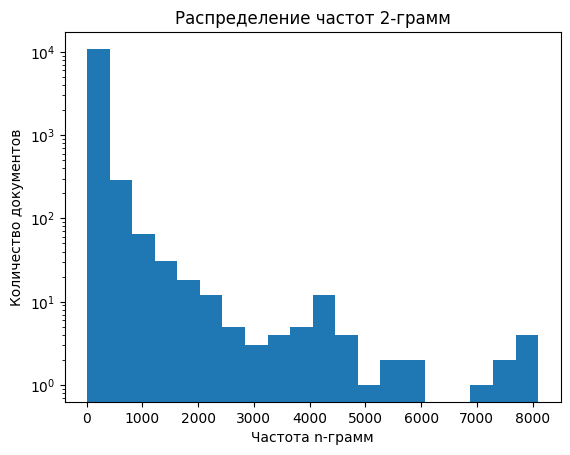

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Настройка n-грамм (например, биграммы)
n = 2  # Для биграмм, можно изменить на 3 для триграмм и т.д.

# Создаем CountVectorizer для извлечения n-грамм
vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')

# Преобразуем обучающие данные в набор n-грамм
X_train_ngram = vectorizer.fit_transform(train_source['data'])

# Преобразуем тестовые данные в набор n-грамм (используя тот же векторизатор)
X_test_ngram = vectorizer.transform(test_source['data'])

# Получаем список всех n-грамм
ngram_list = vectorizer.get_feature_names_out()

# Подсчитываем, сколько раз каждая n-грамма встречается в обучающих документах
ngram_freq = X_train_ngram.toarray().sum(axis=0)

# Получаем 20 самых частых n-грамм
ngram_freq_sorted = sorted(zip(ngram_freq, ngram_list), reverse=True)

# Печать 10 самых частых n-грамм
print("Топ-10 самых частых n-грамм:")
for freq, ngram in ngram_freq_sorted[:10]:
    print(f"{ngram}: {freq}")

# Печать статистики по уникальным n-граммам
print(f"\nКоличество уникальных n-грамм: {len(ngram_list)}")

# Вычисление частоты появления n-грамм в документах (word_doc_freq)
word_doc_freq = []
for doc in X_train_ngram:
    unique_ngrams = set(doc.indices)  # Множество уникальных n-грамм для документа
    word_doc_freq.append(len(unique_ngrams))

# Построение гистограммы распределения частот n-грамм
plt.hist(word_doc_freq, bins=20)
plt.title(f'Распределение частот {n}-грамм')
plt.yscale('log')
plt.xlabel('Частота n-грамм')
plt.ylabel('Количество документов')
plt.show()


## Шаг 5. Векторизация текстов с фильтрацией по частоте n-грамм

In [ ]:
MAX_DF = 0.8  # Максимальная доля документов, в которых может встречаться слово (игнорирование слишком частых слов)
MIN_DF = 5  # Минимальное количество документов, в которых должно встречаться слово (игнорирование слишком редких слов)
NGRAM_RANGE = (1, 2)  # Диапазон N-грамм (используем униграммы и биграммы)

vectorizer_ngram = CountVectorizer(ngram_range=NGRAM_RANGE, min_df=MIN_DF, max_df=MAX_DF)  # Инициализация векторизатора с заданными параметрами

train_vectors_ngram = vectorizer_ngram.fit_transform(train_source['data'])  # Преобразование обучающих текстов в векторное представление
test_vectors_ngram = vectorizer_ngram.transform(test_source['data'])  # Преобразование тестовых текстов в векторное представление

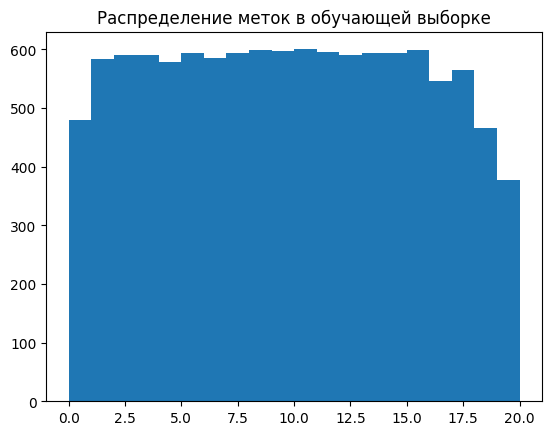

In [ ]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

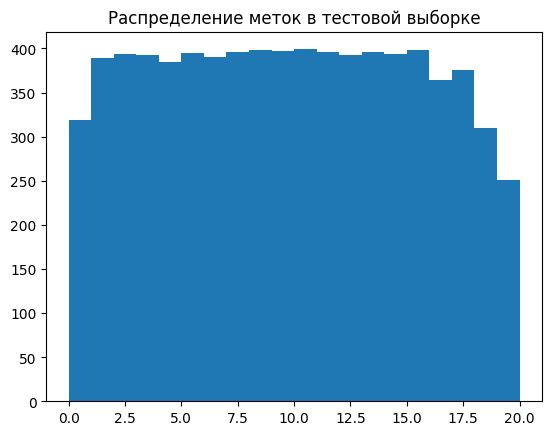

In [ ]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

## Шаг 6. Лемматизация

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer  # Импорт лемматизатора из библиотеки NLTK
import nltk
nltk.download('wordnet')  # Загрузка данных для лемматизатора
nltk.download('punkt_tab')  # Загрузка дополнительных данных токенизатора

lemmatizer = WordNetLemmatizer()  # Создание объекта лемматизатора

# Функция для лемматизации текста
def lemmatize_corpus(corpus):
    return [' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(doc)]) for doc in corpus]
    # Лемматизация каждого слова в документе и соединение их обратно в текст

# Лемматизация обучающего и тестового набора данных
train_lemmatized = lemmatize_corpus(train_source['data'])  # Лемматизация обучающих данных
test_lemmatized = lemmatize_corpus(test_source['data'])  # Лемматизация тестовых данных

# Векторизация лемматизированных текстов через N-граммы
train_vectors_lem = vectorizer_ngram.fit_transform(train_lemmatized)  # Преобразование обучающих данных в N-граммы
test_vectors_lem = vectorizer_ngram.transform(test_lemmatized)  # Преобразование тестовых данных в N-граммы


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Шаг 7. Нейросеть и ее определение

In [ ]:
class TwoLayerNN(nn.Module):  # Определение класса нейронной сети, наследуя nn.Module
    def __init__(self, input_dim, hidden_dim, output_dim):  # Инициализация модели
        super(TwoLayerNN, self).__init__()  # Вызов конструктора базового класса
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Первый полносвязный слой (вход -> скрытый слой)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Второй полносвязный слой (скрытый слой -> выход)

    def forward(self, x):  # Определение прямого прохода данных через модель
        x = F.relu(self.fc1(x))  # Применение ReLU активации после первого слоя
        x = self.fc2(x)  # Вычисление выхода второго слоя
        return x

# Инициализация гиперпараметра скрытого слоя
HIDDEN_DIM = 32  # Размер скрытого слоя

# Создание экземпляра двухслойной нейросети
model_two_layer = TwoLayerNN(
    input_dim=train_vectors_ngram.shape[1],  # Размер входных данных (размер словаря)
    hidden_dim=HIDDEN_DIM,  # Размер скрытого слоя
    output_dim=len(set(train_source['target']))  # Размер выходного слоя (количество классов)
)


In [ ]:
l2_reg_alpha = 1e-4  # Коэффициент L2-регуляризации для предотвращения переобучения модели

## Шаг 8. Фильтрация словаря на основе PMI и обновление векторных представлений

In [ ]:
# Импорт необходимых библиотек для обработки текста
from sklearn.feature_extraction.text import TfidfTransformer  # Используется для преобразования частот слов в TF-IDF
from scipy.sparse import coo_matrix  # Формат для работы с разреженными матрицами

# Определение функции для фильтрации словаря на основе PMI (Pointwise Mutual Information)
def filter_vocabulary_by_pmi(vectors, min_pmi_threshold):
    coo = coo_matrix(vectors)  # Преобразование в разреженную матрицу COO-формата
    word_counts = np.array(vectors.sum(axis=0)).flatten()  # Подсчет количества вхождений каждого слова
    word_pairs = collections.defaultdict(int)  # Словарь для подсчета пар слов

    # Подсчет частоты совместной встречи слов
    for i, j, _ in zip(coo.row, coo.col, coo.data):
        word_pairs[(i, j)] += 1

    pmi_scores = {}  # Словарь для хранения PMI-оценок
    for (i, j), count in word_pairs.items():
        p_ij = count / coo.nnz  # Вероятность совместной встречи
        p_i = word_counts[i] / coo.nnz  # Вероятность первого слова
        p_j = word_counts[j] / coo.nnz  # Вероятность второго слова
        pmi_scores[j] = np.log2(p_ij / (p_i * p_j + 1e-9))  # Расчет PMI с добавлением малой константы для стабильности

    # Фильтрация индексов с PMI выше порога
    filtered_indices = {j for j, score in pmi_scores.items() if score >= min_pmi_threshold}
    return filtered_indices

# Установка порога PMI
PMI_THRESHOLD = 0.5

# Применение фильтрации словаря по PMI
filtered_vocab = filter_vocabulary_by_pmi(train_vectors_ngram, PMI_THRESHOLD)

# Корректная индексация разреженных матриц с учетом отфильтрованного словаря
train_vectors_filtered = train_vectors_ngram[:, sorted(filtered_vocab)]  # Обновленный словарь для обучающих данных
test_vectors_filtered = test_vectors_ngram[:, sorted(filtered_vocab)]  # Обновленный словарь для тестовых данных


## Шаг 9. Обучение модели

In [ ]:
# Определение стратегии изменения скорости обучения (Scheduler)
scheduler = lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)
# Уменьшает скорость обучения в 2 раза, если в течение 5 эпох не улучшается значение функции потерь

# Запуск цикла обучения и валидации модели
best_val_loss, best_model = train_eval_loop(
    model=model_two_layer,  # Двухслойная нейросеть
    train_dataset=SparseFeaturesDataset(train_vectors_filtered, train_source['target']),  # Обучающая выборка
    val_dataset=SparseFeaturesDataset(test_vectors_filtered, test_source['target']),  # Валидационная выборка
    criterion=F.cross_entropy,  # Функция потерь (кросс-энтропия)
    lr=1e-1,  # Начальная скорость обучения
    epoch_n=200,  # Максимальное количество эпох
    batch_size=128,  # Размер батча
    l2_reg_alpha=l2_reg_alpha,  # Коэффициент L2-регуляризации
    lr_scheduler_ctor=scheduler  # Стратегия изменения скорости обучения
)

# Оценка модели на обучающей выборке
train_pred = predict_with_model(best_model, SparseFeaturesDataset(train_vectors_filtered, train_source['target']))
# Предсказания на обучающей выборке
train_loss = F.cross_entropy(torch.from_numpy(train_pred), torch.from_numpy(train_source['target']).long())
# Вычисление функции потерь на обучающей выборке
print('Среднее значение функции потерь на обучении:', float(train_loss))  # Вывод значения функции потерь
print('Доля верных ответов:', accuracy_score(train_source['target'], train_pred.argmax(-1)))  # Точность на обучении

# Оценка модели на тестовой выборке
test_pred = predict_with_model(best_model, SparseFeaturesDataset(test_vectors_filtered, test_source['target']))
# Предсказания на тестовой выборке
test_loss = F.cross_entropy(torch.from_numpy(test_pred), torch.from_numpy(test_source['target']).long())
# Вычисление функции потерь на тестовой выборке
print('Среднее значение функции потерь на тестировании:', float(test_loss))  # Вывод значения функции потерь
print('Доля верных ответов:', accuracy_score(test_source['target'], test_pred.argmax(-1)))  # Точность на тестировании


Эпоха 0
Эпоха: 89 итераций, 15.61 сек
Среднее значение функции потерь на обучении 3.381336462631654
Среднее значение функции потерь на валидации 2.6705319962259066
Новая лучшая модель!

Эпоха 1
Эпоха: 89 итераций, 15.12 сек
Среднее значение функции потерь на обучении 2.292191896545753
Среднее значение функции потерь на валидации 3.7637000285972984

Эпоха 2
Эпоха: 89 итераций, 15.42 сек
Среднее значение функции потерь на обучении 2.3372484298234575
Среднее значение функции потерь на валидации 2.534579624563961
Новая лучшая модель!

Эпоха 3
Эпоха: 89 итераций, 15.55 сек
Среднее значение функции потерь на обучении 2.3007048274693864
Среднее значение функции потерь на валидации 2.5532405012744968

Эпоха 4
Эпоха: 89 итераций, 14.69 сек
Среднее значение функции потерь на обучении 2.592613166637635
Среднее значение функции потерь на валидации 2.7053309699236334

Эпоха 5
Эпоха: 89 итераций, 16.53 сек
Среднее значение функции потерь на обучении 2.4238805837845536
Среднее значение функции потерь

100%|██████████| 354/353.5625 [00:09<00:00, 37.75it/s]


Среднее значение функции потерь на обучении: 0.42573580145835876
Доля верных ответов: 0.9231041187908785


236it [00:06, 33.89it/s]                             

Среднее значение функции потерь на тестировании: 1.9682482481002808
Доля верных ответов: 0.6398035050451407


## Выводы

1. Исходная модель

![image.png](attachment:image.png)


2. Первая модификация модели

![image-3.png](attachment:image-3.png)


3. Вторая модификация модели

![image-4.png](attachment:image-4.png)


4. Финальная модификая модели

![image-5.png](attachment:image-5.png)



**До модификаций:**

Функция потерь на обучении: Очень низкое значение (0.0022), что говорит о почти идеальном обучении модели на тренировочных данных.

Доля верных ответов на обучении: Очень высокая (99.95%), указывающая на переобучение.

Функция потерь на валидации: Значительно выше (0.9289), что подтверждает переобучение.

Точность на валидации: 76.8% — модель показывает ограниченные обобщающие способности.


**После модификаций:**

Функция потерь на обучении: Увеличилась (0.4257), что говорит о снижении уровня переобучения.

Доля верных ответов на обучении: Уменьшилась до 92.31%, что ожидаемо из-за регуляризации и усложнения архитектуры.

Функция потерь на тестировании: Существенно возросла (1.9682), что указывает на ухудшение способности модели обобщать.

Точность на тестировании: Снизилась до 63.98%, что также подтверждает ухудшение качества предсказаний на новых данных.